In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math

mass_1_x = float(input("Enter M1's x position: "))
mass_1_y = float(input("Enter M1's y position: "))
mass_1 = float(input("Enter M1's mass: "))
mass_2_x = float(input("Enter M2's x position: "))
mass_2_y = float(input("Enter M2's y position: "))
mass_2 = float(input("Enter M2's mass: "))

alpha = mass_2 / mass_1
print(
    f"Representing the masses as factors of M1 gives us M1 = 1 * M and M2 = {alpha} * M")

moving_mass_x = float(input("Enter the moving mass's initial x position: "))
moving_mass_y = float(input("Enter the moving mass's initial y position: "))
moving_mass_x_prime = float(
    input("Enter the moving mass's initial x velocity: "))
moving_mass_y_prime = float(
    input("Enter the moving mass's initial y velocity: "))

its = int(input("Enter the number of iterations to perform: "))
delta = float(input("Enter the δt factor (the length of each input): "))


ValueError: could not convert string to float: ''

original: m1: (0, 0), m2: (2.0, 0), m: (-6.000000000000001, 5.999999999999999)
final: m1: (0, 0), m2: (2.0, 0), m: (-6.000000000000002, 5.999999999999997)


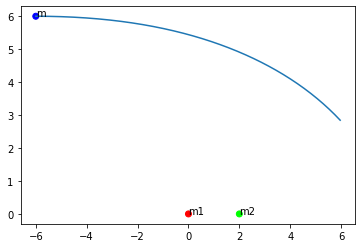

In [2]:
print(
    f"original: m1: ({mass_1_x}, {mass_1_y}), m2: ({mass_2_x}, {mass_2_y}), m: ({moving_mass_x}, {moving_mass_y})")

# Reposition the masses such that M1 is at the origin and M2 lies along the y-axis
# First, move all points
# Then rotate

mass_2_x -= mass_1_x
mass_2_y -= mass_1_y
moving_mass_x -= mass_1_x
moving_mass_y -= mass_1_y

m_theta = np.arctan2(moving_mass_y, moving_mass_x)
m2_theta = np.arctan2(mass_2_y, mass_2_x)

mass_2_x = np.sqrt(mass_2_x ** 2 + mass_2_y ** 2)
mass_2_y = 0
mass_1_x = 0
mass_1_y = 0

# Subtract m2_theta from current m_theta

m_theta -= m2_theta
m_r = np.sqrt(moving_mass_x ** 2 + moving_mass_y ** 2)

# Convert back to cartesian coordinates

moving_mass_x = m_r * np.cos(m_theta)
moving_mass_y = m_r * np.sin(m_theta)

# m1 and m2 should now lay along the x-axis and m should be rotated relative to them
print(
    f"final: m1: ({mass_1_x}, {mass_1_y}), m2: ({mass_2_x}, {mass_2_y}), m: ({moving_mass_x}, {moving_mass_y})")


# declare arrays that will be appended to in loop
x = [moving_mass_x]
y = [moving_mass_y]
x_prime = [moving_mass_x_prime]
y_prime = [moving_mass_y_prime]

# We have the following equations of motion
# x ̇_(n+1)=x ̇_n-δt4π^2 (x_(n+1)/〖r_1^3〗_(n+1) +α(x_(n+1)-d)/〖r_2^3〗_(n+1) )
# y ̇_(n+1)=y ̇_n-δt4π^2 y_(n+1) (1/〖r_1^3〗_(n+1) +α/〖r_2^3〗_(n+1) )

for n in range(its):
    # calculate next x, y, x', and y'
    x_n_plus_one = x[n] + delta * x_prime[n]
    x.append(x_n_plus_one)
    y_n_plus_one = y[n] + delta * y_prime[n]
    y.append(y_n_plus_one)

    x_prime_n_plus_one = x_prime[n] - delta * 4 * (np.pi ** 2) * (x[n + 1] / np.power((x[n + 1] ** 2) + (
        y[n + 1] ** 2), 3 / 2) + alpha * (x[n+1] - mass_2_x) / np.power((x[n + 1] - mass_2_x) ** 2 + y[n + 1] ** 2, 3 / 2))
    x_prime.append(x_prime_n_plus_one)

    y_prime_n_plus_one = y_prime[n] - delta * 4 * (np.pi ** 2) * y[n + 1] * (1 / np.power(
        (x[n + 1] ** 2) + (y[n + 1] ** 2), 3 / 2) + 1 / np.power((x[n + 1] - mass_2_x) ** 2 + y[n + 1] ** 2, 3 / 2))
    y_prime.append(y_prime_n_plus_one)

plt.plot(x, y)

masses = [[mass_1_x, mass_2_x, moving_mass_x],
          [mass_1_y, mass_2_y, moving_mass_y]]
colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])

plt.scatter(masses[0], masses[1], c=colors / 255)

labels = ["m1", "m2", "m"]
for i, txt in enumerate(labels):
    plt.annotate(txt, (masses[0][i], masses[1][i]))

plt.show()
